# Importing libraries

In [35]:
!pip install -q evaluate rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import json
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import time
import torch
from  evaluate import load
from sentence_transformers import SentenceTransformer, util
import re
from google.colab import drive


# Modelling

In [41]:
# Loading a single JSONL file generated after data processing

data_files = {
    "train": "/content/train.jsonl",
    "test": "/content/test.jsonl",
    "val": "/content/val.jsonl"
}

raw_datasets = load_dataset("json", data_files=data_files)

train_dataset = raw_datasets["train"]
test_dataset = raw_datasets["test"]
val_dataset = raw_datasets["val"]

print(raw_datasets)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 5781
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 721
    })
    val: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 725
    })
})


In [42]:
print(raw_datasets.keys())

dict_keys(['train', 'test', 'val'])


In [7]:
raw_datasets["train"][0]

{'instruction': 'Answer the following AWS FAQ question',
 'input': 'What are my options for running Microsoft software that is approaching EOS?',
 'output': 'AWS customers running EOS software on EC2 instances have several options: [Source: https://aws.amazon.com/windows/faq/]'}

In [8]:
model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto", device_map="auto")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [9]:
if hasattr(model, 'generation_config') and model.generation_config is not None:
    print("Values from model.generation_config:")
    print(model.generation_config)

    max_new_tokens = getattr(model.generation_config, "max_new_tokens", "Not set")
    num_return_sequences = getattr(model.generation_config, "num_return_sequences", "Not set")

    print(f"\nmax_new_tokens: {max_new_tokens}")
    print(f"num_return_sequences: {num_return_sequences}")

else:
    print("Model does not have a generation_config or it is not set.")

Values from model.generation_config:
GenerationConfig {
  "bos_token_id": 151646,
  "do_sample": true,
  "eos_token_id": 151643,
  "temperature": 0.6,
  "top_p": 0.95
}


max_new_tokens: None
num_return_sequences: 1


In [10]:
# Tokenizing data

def tokenize(example):
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    target = example['output']
    return tokenizer(
        prompt,
        text_target=target,
        truncation=True,
        padding="max_length",    # Ensures each input-output pair fits within 512 tokens.
        max_length=512,
    )

tokenized_train_dataset = train_dataset.map(tokenize,batched=False,remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(tokenize,batched=False,remove_columns=val_dataset.column_names)
tokenized_test_dataset = test_dataset.map(tokenize,batched=False,remove_columns=test_dataset.column_names)


Map:   0%|          | 0/5781 [00:00<?, ? examples/s]

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

In [11]:
# Revieving DatasetDict splits

print(tokenized_val_dataset)


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 725
})


In [12]:
print(tokenized_train_dataset['input_ids'][:5])

[[151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643

In [13]:

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj", "down_proj"], # Lora application on 7 layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 4,616,192 || all params: 1,781,704,192 || trainable%: 0.2591


In [14]:


training_args = TrainingArguments(
    output_dir="/content/deepseek_aws_faq_model",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=0.5,
    eval_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,   #  fine-tuning
    val_dataset=tokenized_val_dataset,  # validation
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start time
start_time = time.time()

# Track initial memory (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()
else:
    start_mem = 0

trainer.train()

# End time
end_time = time.time()

# Compute memory used
if torch.cuda.is_available():
    peak_mem = torch.cuda.max_memory_allocated()
    used_mem_MB = (peak_mem - start_mem) / (1024 ** 2)
else:
    used_mem_MB = 0

/tmp/ipython-input-3569757561.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,3.766300,2.579819
20,2.457800,2.182662
30,2.137700,1.929057
40,1.881900,1.894702
50,1.861800,1.866062
60,1.727600,1.845273
70,1.880200,1.826434
80,1.820000,1.800577
90,1.814600,1.785277
100,1.736900,1.768555


# Validation

In [18]:
# Training duration
training_time = end_time - start_time

# Print Resources used
print(f"🕒 Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"💾 Peak Model Training GPU Memory Used : {used_mem_MB:.2f} MB")

🕒 Training Time: 2597.48 seconds (43.29 minutes)
💾 Peak Model Training GPU Memory Used : 14023.64 MB


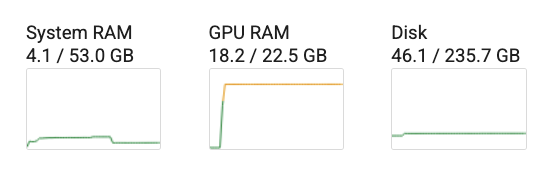

In [19]:
pd.DataFrame(trainer.state.log_history)[["step", "eval_loss"]].dropna().tail(10)


,step,eval_loss
54,270,1.642278
56,280,1.639833
58,290,1.638453
60,300,1.634680
62,310,1.631245
64,320,1.629501
66,330,1.627470
68,340,1.625599
70,350,1.624536
72,360,1.624013


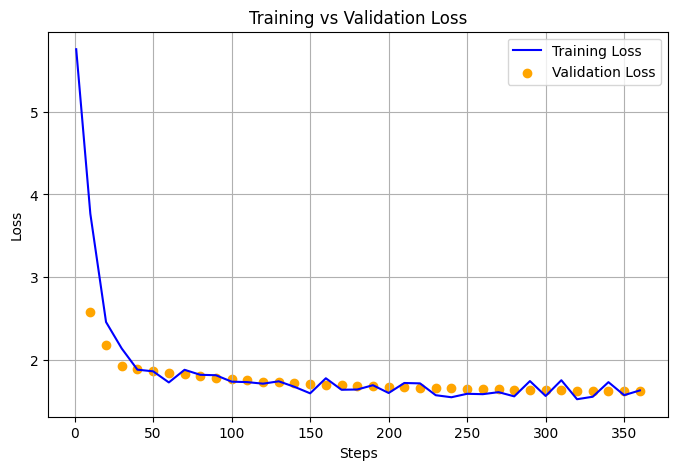

In [34]:
loss_df = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(8, 5))

# Training loss
train_loss_df = loss_df.dropna(subset=["loss"])
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Training Loss", color="blue")

# Validation loss
eval_loss_df = loss_df.dropna(subset=["eval_loss"])
plt.scatter(eval_loss_df["step"], eval_loss_df["eval_loss"], label="Validation Loss", color="orange")


plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

In [38]:

STOP_MARKERS = [
    "\nInput:", "\nUser:", "\nExplanation:", "\nTranscribed",
    "\nQuestion:", "\nQ:", "\nAnswer:", "\nOutput:"
]

def extract_answer(full_text: str) -> str:
    # Find the first "Output:" block
    m = re.search(r"Output:\s*(.*)", full_text, flags=re.DOTALL)
    ans = m.group(1).strip() if m else full_text.strip()

    # Cut at earliest stop marker (if any)
    cut_idx = len(ans)
    for marker in STOP_MARKERS:
        i = ans.find(marker)
        if i != -1:
            cut_idx = min(cut_idx, i)
    return ans[:cut_idx].strip()


In [39]:

# Evaluating only first 213 test samples out of 725 for faster evaluation
test_samples = test_dataset.select(range(213))

# Load metrics
rouge = load("rouge")
bleu = load("bleu")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Ensuring model is in evaluation mode
model.eval()

predictions = []
references = []
questions = []
actual_answers = []
generated_answers = []

for example in test_samples:
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=100)

    generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the generated answer part after "Output:"
    if "Output:" in generated_answer:
        generated_answer = generated_answer.split("Output:", 1)[1].strip()
    # Further split by "Input:" if it appears in the generated text and take the first part
    if "Input:" in generated_answer:
        generated_answer = generated_answer.split("Input:", 1)[0].strip()


    predictions.append(generated_answer)
    references.append(example["output"])
    questions.append(example["input"])
    actual_answers.append(example["output"])
    generated_answers.append(generated_answer)


# Compute metrics
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
semantic_sim = [util.cos_sim(sbert.encode(p), sbert.encode(r)).item() for p, r in zip(predictions, references)]

# Print Results
print("🔍 BLEU:", bleu_score["bleu"])
print("🔍 ROUGE:", rouge_score)
print("🔍 SBERT Semantic Similarity (avg):", np.mean(semantic_sim))


# Export to Excel
output_df = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer': generated_answers
})

output_excel_path = "/content/DeepSeek_Model1_generated_answers.xlsx"
output_df.to_excel(output_excel_path, index=False)
print(f"Results saved to {output_excel_path}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for

🔍 BLEU: 0.018265778121403228
🔍 ROUGE: {'rouge1': np.float64(0.24037239310310396), 'rouge2': np.float64(0.06404438000581197), 'rougeL': np.float64(0.17185002107707714), 'rougeLsum': np.float64(0.17234500823591598)}
🔍 SBERT Semantic Similarity (avg): 0.6485593308445433
Results saved to /content/DeepSeek_Model1_generated_answers.xlsx


# Saving Model

In [21]:
# Saving model and tokenizer to drive

drive.mount('/content/drive')
model.save_pretrained("/content/drive/MyDrive/DeepSeek_Model1")
tokenizer.save_pretrained("/content/drive/MyDrive/DeepSeek_Model1")

Mounted at /content/drive


('/content/drive/MyDrive/DeepSeek_Model1/tokenizer_config.json',
 '/content/drive/MyDrive/DeepSeek_Model1/special_tokens_map.json',
 '/content/drive/MyDrive/DeepSeek_Model1/chat_template.jinja',
 '/content/drive/MyDrive/DeepSeek_Model1/tokenizer.json')

In [22]:
# Load model

drive_path = "/content/drive/MyDrive/DeepSeek_Model1"

model = AutoModelForCausalLM.from_pretrained(drive_path, torch_dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(drive_path, trust_remote_code=True)


In [23]:
# Display the first 100 samples from the test dataset
print(test_dataset.select(range(100)))

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 100
})


In [24]:

for sample in test_dataset.select(range(100)):
    print(sample)


{'instruction': 'Answer the following AWS FAQ question', 'input': 'Which AWS regions offer server-side encryption for Kinesis Data Streams?', 'output': 'Kinesis Data Streams server-side encryption is available in the AWS GovCloud Region and all public Regions except the China (Beijing) Region. [Source: https://aws.amazon.com/kinesis/data-streams/faqs/]'}
{'instruction': 'Answer the following AWS FAQ question', 'input': 'Can I lock a document to prevent it from receiving further feedback?', 'output': 'Yes, you can disable feedback for a document and prevent it from receiving additional comments. You can re-enable feedback and users will be able to post comments again. [Source: https://aws.amazon.com/workdocs/faq/]'}
{'instruction': 'Answer the following AWS FAQ question', 'input': 'Can I customize pricing or terms for select customers?', 'output': 'Yes. Private offers allow you to make public products available to select AWS customers and to set terms including price, duration, payment 

# Testing on user query

In [28]:

question = "What are Amazon EC2 A1 instances??"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs,max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Amazon EC2 A1 instances are Amazon EC2 instances with 64 vCPUs and 64 GB of on-chip memory. They are single instances with 64 vCPUs, 64 GB of memory, and 2.5 GB of shared storage. Each instance has 64 vCPUs, 64 GB of memory, and 2.5 GB of shared storage.
Note: A1 instances are single instance instances with 64 vCP


In [30]:
question = "What is an ec2 service?"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


An EC2 service is a virtualized instance that can be used to run applications on the EC2 virtual private cloud (VPC). EC2 services include EC2 instances, EC2 instances with auto-scaling, EC2 instances with auto-continuation, EC2 instances with auto-rotation, and EC2 instances with auto-restart. EC2 instances are virtual instances that can be used to run applications on the EC2 virtual private cloud (VPC).


In [31]:
question = "What is Savings Plans and their types"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Savings Plans is a set of automated payment methods that can be used to transfer funds from a source to a destination account. They can be used for a variety of purposes, including making payments, transferring money, and transferring assets. There are two main types: one for paying for services and one for transferring money. The savings plans can be configured to use different methods, such as credit card, bank transfer, or wire transfers.


In [32]:
question = "What ARE AWS Savings Plans and their types"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(answer)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


AWS Savings Plans are AWS managed savings accounts that allow you to save money on your AWS bills. The savings accounts are managed by Amazon S3 with the ability to track your savings history and manage your account through Amazon S3. You can use your AWS Savings Plan to track your usage of Amazon S3, your usage of Amazon S3 Object Storage (S3OS), and your usage of Amazon S3 Backup. You can also use your AWS Savings Plan to monitor your AWS bill bill history, and
